## Task 4: Explainability through Grad-CAM

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib as mpl
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras import Input, Model
import math
from tensorflow.keras.preprocessing import image

from funcs_Task1 import training_data_Pipeline, test_validation_data_Pipeline, get_normalization_numbers
from funcs_Task2_3 import concat_generators

In [2]:
# constants
img_size = (128, 128)
train_dir = 'covid xray/train'
val_dir = 'covid xray/val'
test_dir = 'covid xray/test'

### 1. Grad-CAM implementation

In [3]:
# function to preprocess image
def preprocess_specific_image(img_path, img_size, train_dir):
    # Load the specific image
    img = image.load_img(img_path, target_size=img_size)

    # Convert the image to an array
    img_array = image.img_to_array(img)

    # Expand dimensions to match the batch format expected by the model
    img_array = np.expand_dims(img_array, axis=0)

    # Get normalization parameters from the training set
    global_mean, global_std = get_normalization_numbers(img_size, train_dir)  # Adjust path

    # Apply normalization
    img_array = (img_array / 255.0 - global_mean) / global_std

    return tf.convert_to_tensor(img_array)

In [4]:
# Load model and remove final activation (softmax)
# model = load_model("covid_xray_baseline_model.keras")
# model = load_model("covid_xray_baseline_model.keras")
# model.layers[-1].activation = None

# select test sample and preprocess
img_path = "covid xray/test/NORMAL/NORMAL-2030.png"
img_array = preprocess_specific_image(img_path, img_size, train_dir)

Found 1600 images belonging to 2 classes.


In [6]:
[i.name for i in model.layers]

NameError: name 'model' is not defined

In [7]:
## redefine model to define it in a way to be able to retract the output of a layer
learning_rate = 0.001
dropout_rate = 0.3
filters = 64

inputs = Input(shape=(128, 128, 3))
x = Conv2D(filters, (3, 3), activation='relu')(inputs)
x = MaxPooling2D(2, 2)(x)
x = BatchNormalization()(x)
x = Conv2D(filters, (3, 3), activation='relu')(x) 
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(1, activation='sigmoid')(x)  

redefined_model = Model(inputs, outputs)

redefined_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=["accuracy"]
)

train_data_gen = training_data_Pipeline(128, img_size, train_dir)
val_data_gen = test_validation_data_Pipeline(128, img_size, train_dir, val_dir)
full_data_gen = concat_generators(train_data_gen, val_data_gen)

total_train = train_data_gen.samples + val_data_gen.samples

history = redefined_model.fit(
         full_data_gen,
         batch_size = 128, 
         epochs = 29,
         steps_per_epoch =  math.ceil(total_train / 128)
        )

redefined_model.layers[-1].activation = None

Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Epoch 1/29
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5459 - loss: 5.0707
Epoch 2/29
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.6440 - loss: 0.6439
Epoch 3/29
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.6470 - loss: 0.5861
Epoch 4/29
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6561 - loss: 0.5725
Epoch 5/29
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.6860 - loss: 0.5296
Epoch 6/29
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.6911 - loss: 0.5170
Epoch 7/29
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.6879 - loss: 0.5047
Epoch 8/29
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7101 - loss: 0.4833
Epoch 9/29
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7358 - loss: 0.4694
Epoch 10/29
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.7081 - loss:

In [8]:
redefined_model.layers[-5].name

'max_pooling2d_1'

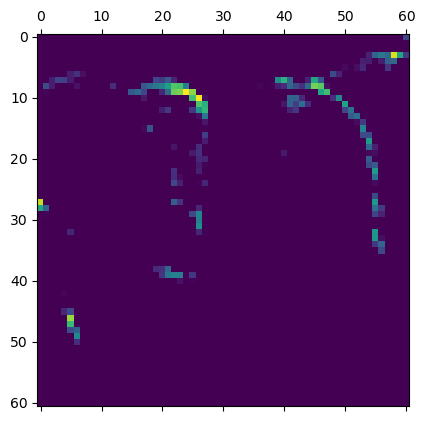

In [9]:
# function getting heatmap for Grad-CAM
def make_gradcam_heatmap(img_array, model, target_layer_name, class_pred = 1):

    target_layer = model.get_layer(target_layer_name) 

    feature_extractor = keras.models.Model(
        inputs= model.input,
        outputs=[target_layer.output, model.output]
    )

    # Forward and backward passes
    with tf.GradientTape() as tape:
        # Evaluate and extract convolutional layer's output
        conv_outputs, preds = feature_extractor(img_array)
        
        # adapt for binary classification with only one class output
        if class_pred == 1:
            class_channel = preds[:, 0]
        if class_pred == 0:
            class_channel = -preds[:, 0]  # Complement of the scalar output
    tape.watch(conv_outputs)
    # compute the gradients and average among channel dimenstions
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # get heatmap
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    #normalization between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array,
    redefined_model,
    target_layer_name=redefined_model.layers[-6].name,
    class_pred= 1
)

plt.matshow(heatmap)


In [21]:
# function overlaying heatmap on original picture
def get_gradcam_image(img_path, heatmap, alpha=0.4, threshold=0.4, cmap='jet'):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.maximum(heatmap, threshold)
    heatmap = (heatmap - threshold) / (heatmap.max() - threshold + 1e-8)  # Normalize after thresholding

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps[cmap]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    return(superimposed_img)


### 2. Explaining the decision with Grad-CAM

In [22]:
## divide test data into groups
# gather necessary data
test_data_gen = test_validation_data_Pipeline(200, img_size, train_dir, test_dir, shuffle = False)
y_pred_probs = redefined_model.predict(test_data_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_data_gen.classes

filepaths = test_data_gen.filepaths
class_indices = test_data_gen.class_indices

# save filepaths of images in 4 classes, based on right or wrong classification and true value
y_pred_covid = (y_pred == class_indices["COVID"])
y_true_covid = (y_true == class_indices["COVID"])

Covid_misclassified = [filepaths[i] for i in range(len(filepaths)) if y_true_covid[i] & ~y_pred_covid[i]]
Covid_correctclassified = [filepaths[i] for i in range(len(filepaths))  if y_true_covid[i] & y_pred_covid[i]]
normal_misclassified = [filepaths[i] for i in range(len(filepaths))  if ~y_true_covid[i] & y_pred_covid[i]]
normal_correctclassified = [filepaths[i] for i in range(len(filepaths))  if ~y_true_covid[i] & ~y_pred_covid[i]]


Found 1600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


c:\Users\Marcin\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step


In [23]:
# sanity check classes
len(Covid_misclassified)+len(Covid_correctclassified)+len(normal_correctclassified)+len(normal_misclassified)

200

In [27]:
# function plotting some images with grad-cam
def show_some_gradcams_from_list(list, img_size, model, class_pred, train_dir, start_index = 0, stop_index = 5 ):
    plt.figure(figsize=(15, 6))
    for i, img_path in enumerate(list[start_index:stop_index]):
        # make gradcam image
        img_array = preprocess_specific_image(img_path, img_size, train_dir)
        heatmap = make_gradcam_heatmap(img_array, model, target_layer_name=model.layers[-5].name, class_pred=class_pred)
        img = get_gradcam_image(img_path, heatmap, threshold = 0.1, cmap = 'plasma')

        # plot gradcam image
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.


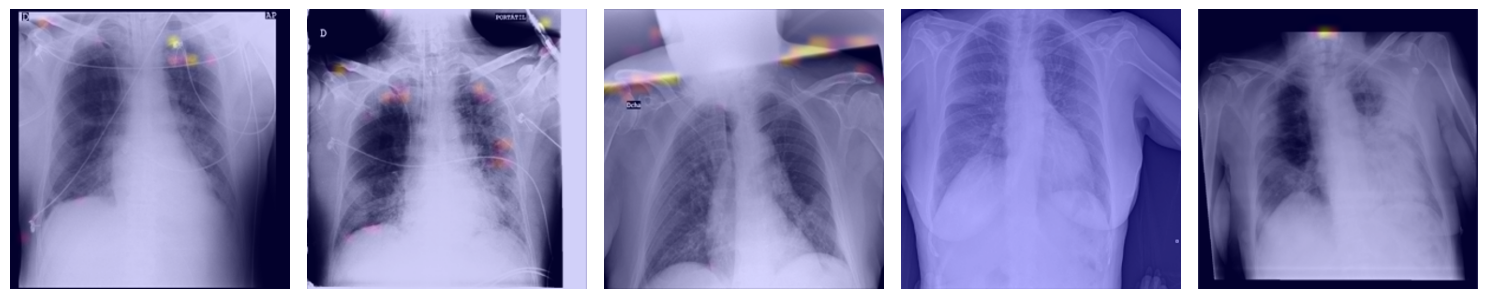

In [28]:
#Covid cases that are misclassified by the model as normal
show_some_gradcams_from_list(Covid_misclassified, img_size, redefined_model, train_dir= train_dir, start_index = 0, stop_index = 5, class_pred= class_indices["NORMAL"])

Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.


C:\Users\Marcin\AppData\Local\Temp\ipykernel_72920\332191400.py:11: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.


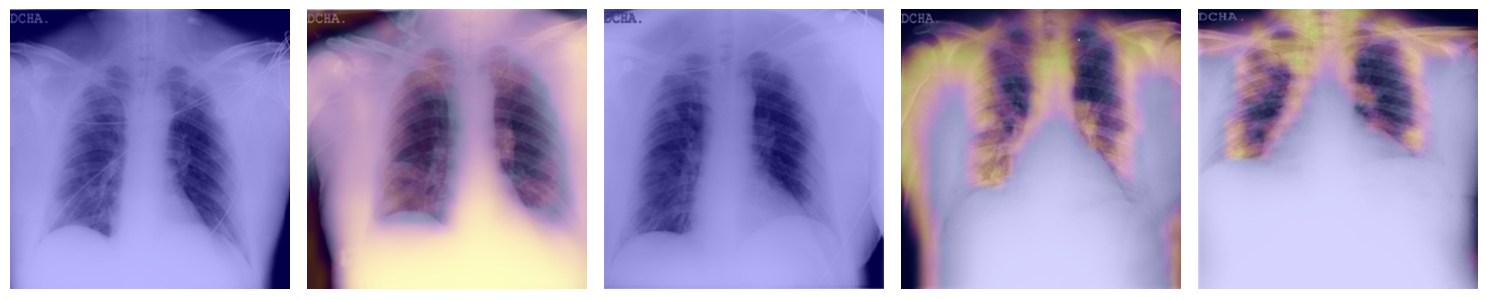

In [29]:
#Covid cases that are correctly classified by the model 
show_some_gradcams_from_list(Covid_correctclassified, img_size, redefined_model, train_dir= train_dir, start_index = 0, stop_index = 5, class_pred= class_indices["COVID"])

Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.


C:\Users\Marcin\AppData\Local\Temp\ipykernel_72920\332191400.py:11: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.


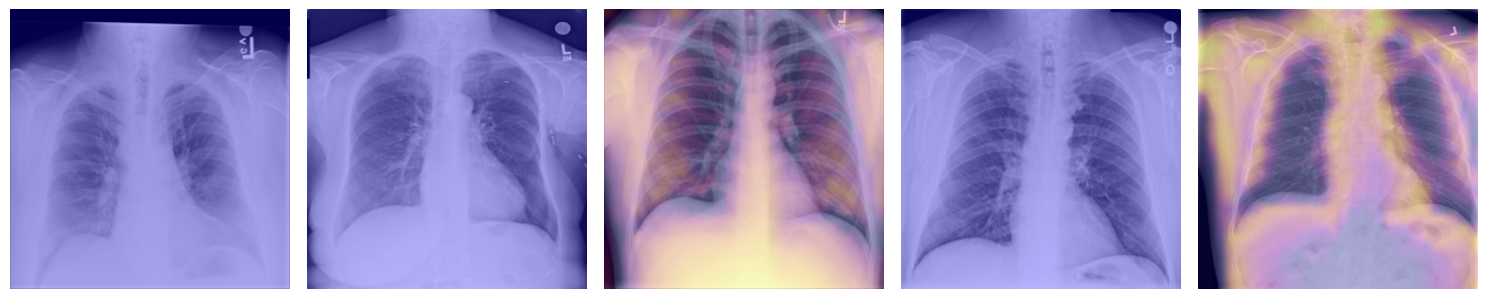

In [32]:
#normal cases that are incorrectly classified by the model as covid cases
show_some_gradcams_from_list(normal_misclassified, img_size, redefined_model, train_dir= train_dir, start_index = 0, stop_index = 5, class_pred=  class_indices["COVID"])


Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.


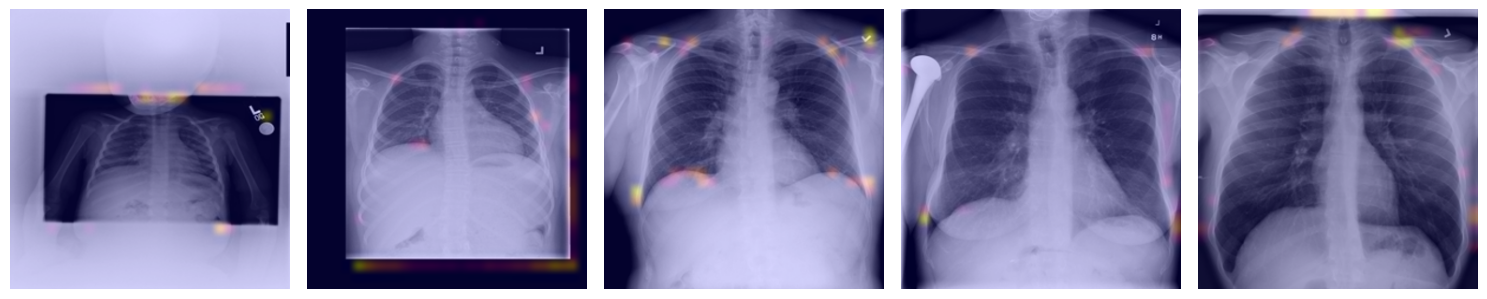

In [34]:
#normal cases that are correctly classified by the model
show_some_gradcams_from_list(normal_correctclassified, img_size, redefined_model, train_dir= train_dir, start_index = 0, stop_index = 5, class_pred=  class_indices["NORMAL"] )